`/interactive-runner`

In [1]:
!rm -rf /kaggle/working/data
!rm /kaggle/working/data.zip
!rm results.csv
!rm -rf /kaggle/working/artefacts

rm: cannot remove 'results.csv': No such file or directory


In [2]:
!pip install gdown
#import gdown
#from cld_data_processing import download_data

`/model/util.py`

In [7]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.data import Dataset
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from typing import NamedTuple, Tuple


class Params(NamedTuple):
    """
    Job Parameters Struct
    """
    image_size: int
    batch_size: int
    epochs: int
    epsilon: float
    early_stopping: bool
    early_stopping_patience: int
    adjust_learning_rate: bool


@dataclass
class ModelWrapper():
    """
    Util class to hold the "outer" model, and the inner base model
    so that training can be fine-tuned.
    """
    
    model: keras.Model
    base_model: keras.Model

        
def create_convnext_base(params: Params) -> ModelWrapper:
    return create_model(tf.keras.applications.ConvNeXtBase, "baseline", DEFAULT_PARAMS)


def create_model(base_model_fn: str, name: str, params: Params) -> ModelWrapper:
    """
    Create Keras application model, e.g.
        tf.keras.applications.EfficientNetV2B0
        tf.keras.applications.ConvNeXtBase
    with a custom top.
    """
    # i = 0
    # name=f"{name}-{(i:=i+1)}"
    # name = [name+str(i) for i in range(17)]
    inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
    # Base
    base_model = base_model_fn(weights='imagenet', include_top=False)
    base_model.trainable = False
    # set training=F here per https://keras.io/guides/transfer_learning/
    x = base_model(inputs, training=False)
    # Head
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    return ModelWrapper(model, base_model)


def run_task(task_id: str, model_wrapper: ModelWrapper,
             ds_train: Dataset, ds_valid: Dataset, ds_test: Dataset,
             params: Params, weights = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    model = model_wrapper.model
    # train
    df_train = train(task_id, model, ds_train, ds_valid, params)
    # test
    test_result = model.evaluate(ds_test)
    df_test = create_test_record(task_id, test_result)
    # save CM too
    save_confusion_matrix(ds_test, model, task_id)
    return df_train, df_test


def train(task_id: str, model: Model,
             ds_train_: Dataset, ds_valid_: Dataset,
             params: Params, weights = None) -> pd.DataFrame:
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=params.epsilon),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.001, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs,
        class_weight=weights
    )
   
    df_hist = pd.DataFrame(history.history)
    # df_hist = df_hist.reset_index()
    df_hist["task_id"] = task_id
    df_hist["epoch"] = df_hist.index
   
    return df_hist


def create_test_record(task_id: str, result: list[float]):
    return pd.DataFrame({"task_id": [task_id], "test_loss" : [result[0]], "test_accuracy": [result[1]]})


def save_confusion_matrix(ds: Dataset, model: Model, task_id: str) -> None:
    path = f"artefacts/conf_mat_{task_id}.png"
    probabilities = model.predict(ds)
    predictions = np.argmax(probabilities, axis=1)

    one_hot_labels = np.concatenate([y for x, y in ds], axis=0)
    labels = [np.argmax(x) for x in one_hot_labels]
    
    result = confusion_matrix(labels, predictions, labels=[0,1,2,3,4], normalize='pred')
    disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
    disp.plot()
    disp.ax_.set_title(task_id)
    
    print(f"Saving confusion matrix to {path}")
    disp.figure_.savefig(f"artefacts/conf_mat_{task_id}.png", dpi=300)

`/data/data_processing.py`

In [8]:
import gdown
import keras
import pandas as pd
import shutil
import tensorflow as tf
import os
import zipfile

# handle different dir structure kaggle vs colab
try:
    from AMLS_II_assignment23_24.model.util import Params
except ModuleNotFoundError:
    pass

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory

from typing import Tuple


def data_preprocessing(path: Path,
                       params: Params,
                       force=False) -> Tuple[Dataset, Dataset, Dataset, dict]:
    """
    """
    file = download_data(path, force)
    
    data_path = path / "data"
    if force:
        shutil.rmtree(data_path)
        
    if not data_path.exists():
        data_path.mkdir(parents=True, exist_ok=True)
       
        with zipfile.ZipFile(file, "r") as z:
            z.extractall(data_path)
        
    df_images = pd.read_csv((data_path / "train.csv"))
    
#     imgs1 = random.sample(df_images[df_images.label==3].image_id.tolist(), k=2577)
#     imgs2 = df_images[df_images.label!=3].image_id.tolist()
    
#     df_images = df_images[df_images.image_id.isin((imgs1+imgs2))].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(df_images.image_id, df_images.label, test_size=0.2, random_state=12)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=12)
    
    train_path = create_ds_tree(X_train, y_train, data_path, "train")
    valid_path = create_ds_tree(X_valid, y_valid, data_path, "valid")
    test_path = create_ds_tree(X_test, y_test, data_path, "test")
    
    ds_train = create_dataset(train_path, params.image_size, params.batch_size)
    ds_valid = create_dataset(valid_path, params.image_size, params.batch_size)
    ds_test = create_dataset(test_path, params.image_size, params.batch_size, False)

    return ds_train, ds_valid, ds_test, extract_class_weights(df_images)


def download_data(path: Path, force=False) -> Path:
    """
    """
    url = "https://drive.google.com/uc?id=1TJBf1HZxAMpowZ92BcgS5N_NPHE7LPOT"
    output = path / "data.zip"
    if not Path(output).exists() or force:
        gdown.download(url, str(output), quiet=False)
    return output


def create_ds_tree(x, y, path: Path, name: str) -> Path:
    """
    Creates the directory structure for the given dataset.
    """
    ds_path = path / name
    if not ds_path.exists():
        ds_path.mkdir(parents=True, exist_ok=True)

        for lab in y.unique():
            (ds_path / str(lab)).mkdir(exist_ok=True)

        source_path = path / "train_images"
        
        for img, lab in zip(x, y):
            src = source_path / img
            dest = ds_path / str(lab) / img
            shutil.move(src, dest)
        
    return ds_path


def create_dataset(path: Path, img_size: int, batch_size: int, shuffle = True) -> Dataset:
    """
    """
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[img_size, img_size],
        batch_size=batch_size,
        seed=12345,
        shuffle=shuffle
    )


def extract_class_weights(df_data: pd.DataFrame) -> dict:
    classes = df_data.label.unique()
    class_weights = compute_class_weight(class_weight='balanced',
                                         classes=classes,
                                         y=df_data.label)

    return dict(zip(classes, class_weights))


def augment_dataset(ds: Dataset, num_repeats: int) -> Dataset:
    """
    """
    def augment(image, label):
        seed = 12345
        image = tf.image.random_flip_left_right(image, seed)
        image = tf.image.random_flip_up_down(image, seed)
        image = tf.image.random_brightness(image, 0.2, seed)
        return image, label

    return (
        ds
        .repeat(num_repeats)
        .map(augment)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )

In [9]:
class ResultCollector():
    
    def __init__(
        self,
        path: Path
    ):
        self.path = path
        self.train_details = pd.DataFrame
        self.test_scores = pd.DataFrame

    def add_task_results(self, df_train, df_test) -> None:
        self.add_train_details(df_train)
        self.add_test_scores(df_test)
        
    def add_train_details(self, df: pd.DataFrame) -> None:
        if self.train_details.empty:
            self.train_details = df
        else:
            self.train_details = pd.concat([self.train_details, df])
        
        self._save(self.train_details, "train_details.csv")
        

    def get_train_details(self) -> pd.DataFrame:
        return self.train_details
    
    def add_test_scores(self, df: pd.DataFrame) -> None:
        if self.test_scores.empty:
            self.test_scores = df
        else:
            self.test_scores = pd.concat([self.test_scores, df])
            
        self._save(self.test_scores, "test_scores.csv")
            
    def get_test_scores(self) -> pd.DataFrame:
        return self.test_scores
    
    def _save(self, df: pd.DataFrame, name: str) -> None:
        df.to_csv(self.path / name, index=False)

`main.py`

Params(image_size=255, batch_size=196, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
==== Loading Data ====
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Class Weights: {0: 3.9368905243790246, 3: 0.3252317981456148, 1: 1.954956601187757, 2: 1.7935456831517183, 4: 1.6606131160263873}
==== Task A: Baseline Model ====
Using EarlyStopping
Epoch 1/50


W0000 00:00:1711658558.230138      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711658558.230480      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711658558.231064      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/66 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5929 - loss: 1.1824

W0000 00:00:1711658650.509466      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711658650.509778      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711658650.510361      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5934 - loss: 1.1803

W0000 00:00:1711658659.871220      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711658659.871563      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711658659.872005      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711658690.030251     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711658690.030573     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711658690.031083     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.5939 - loss: 1.1783 - val_accuracy: 0.7136 - val_loss: 0.7777
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.6787 - loss: 0.8507 - val_accuracy: 0.7460 - val_loss: 0.6821
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7168 - loss: 0.7511 - val_accuracy: 0.7680 - val_loss: 0.6378
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7387 - loss: 0.6952 - val_accuracy: 0.7834 - val_loss: 0.5905
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7653 - loss: 0.6430 - val_accuracy: 0.7960 - val_loss: 0.5671
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7702 - loss: 0.6217 - val_accuracy: 0.8005 - val_loss: 0.5515
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7816 - loss: 0.5943 - val_accuracy: 0.8054 - val_loss: 0.5249
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7880 - loss: 0.5773 - val_accuracy: 0.8112 - val_loss: 0.

W0000 00:00:1711661845.337014      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711661845.337362      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711661845.337841      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step


W0000 00:00:1711661876.429959      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711661876.430345      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711661876.430827      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_A_base.png


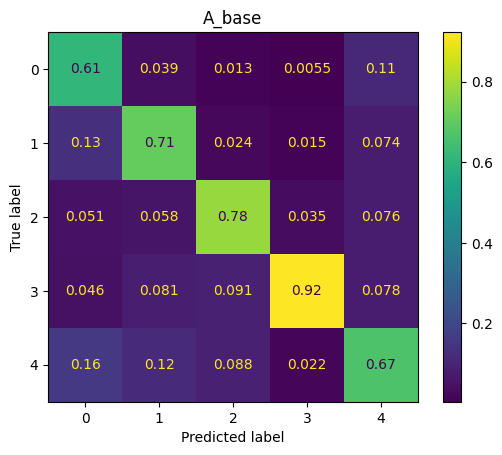

In [10]:
import os
import pandas as pd
import tensorflow as tf

# handle different dir structure kaggle vs colab
try:
    from AMLS_II_assignment23_24.data_processing import pre_processing as data
    from AMLS_II_assignment23_24.model import util as model_util
    from AMLS_II_assignment23_24.model.util import Params, ResultCollector
except ModuleNotFoundError:
    pass

from docopt import docopt
from pathlib import Path

tf.random.set_seed(67890)

DEFAULT_PARAMS = Params(255, 196, 50, 0.005, True, 5, False)
## DEFAULT_PARAMS = model_util.Params(50, 196, 1, True, 5, False)
#DEFAULT_PARAMS = Params(50, 196, 1, 0.005, True, 5, False)
print(DEFAULT_PARAMS)

ARTEFACTS_PATH = Path("artefacts")
ARTEFACTS_PATH.mkdir(parents=True, exist_ok=True)

collector = ResultCollector(ARTEFACTS_PATH)

# Process Data
print("==== Loading Data ====")
cwd = os.getcwd()
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), DEFAULT_PARAMS)
print(f"Class Weights: {class_weights}")

print("==== Task A: Baseline Model ====")

model = create_convnext_base(DEFAULT_PARAMS)
df_train, df_test = run_task("A_base", model, ds_train, ds_valid, ds_test, DEFAULT_PARAMS)
collector.add_task_results(df_train, df_test)

# print("==== Task B: Baseline + Data Augmentation ====")
# {
#     """
#     Per task A, but with data augmentation.
#     """
#     ds_train_aug = augment_dataset(ds_train, 2)
#     model = create_convnext_base(DEFAULT_PARAMS)
#     df_train, df_test = run_task("B_base_aug", model, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS)
#     collector.add_task_results(df_train, df_test)    
# }

# print("==== Task C: Baseline + Data Augmentation + Class Weights ====")
# model = create_convnext_base(DEFAULT_PARAMS)
# {
#     """
#     Per task B but, given the large class imbalance, class weight supplied.
#     """
#     ds_train_aug = augment_dataset(ds_train, 2)
#     df_train, df_test = run_task("C_base_aug_wgts", model, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS, class_weights)
#     collector.add_task_results(df_train, df_test)    
# }

# print("==== Task D: Baseline + Data Augmentation + Class Weights + Fine Tune ====")
# {
#     """
#     Per task C but, given the large class imbalance, class weight supplied.
#     """
#     fine_tune_params = Params(50, 196, 1, 1e-5, True, 5, False)
#     print(fine_tune_params)
#     model.base_model.trainable = True
#     ds_train_aug = augment_dataset(ds_train, 2)
#     df_train, df_test = run_task("D_base_aug_wgts_ft", model, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS, class_weights)
#     collector.add_task_results(df_train, df_test)    
# }


In [21]:
model.model.save("/kaggle/working/artefacts/model_a.keras")

In [12]:
import datetime

2024-03-28 21:39:04.603148
Using EarlyStopping
Epoch 1/50


W0000 00:00:1711661977.625788      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711661977.626165      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711661977.626840      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 65/132 ━━━━━━━━━━━━━━━━━━━━ 1:26 1s/step - accuracy: 0.5593 - loss: 1.2572

W0000 00:00:1711662071.349629      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711662071.349949      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711662071.350535      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5984 - loss: 1.1296

W0000 00:00:1711662166.543439     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711662166.543824     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711662166.544307     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711662196.997712      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711662196.998148      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711662196.998568      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.5988 - loss: 1.1283 - val_accuracy: 0.7554 - val_loss: 0.6936
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.7235 - loss: 0.7334 - val_accuracy: 0.7867 - val_loss: 0.5985
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.7674 - loss: 0.6453 - val_accuracy: 0.8035 - val_loss: 0.5541
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.7839 - loss: 0.5931 - val_accuracy: 0.8091 - val_loss: 0.5302
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.7973 - loss: 0.5604 - val_accuracy: 0.8131 - val_loss: 0.5151
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8085 - loss: 0.5314 - val_accuracy: 0.8171 - val_loss: 0.4953
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8157 - loss: 0.5048 - val_accuracy: 0.8215 - val_loss: 0.4979
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8245 - loss: 0.4865 - val_accuracy: 0.823

W0000 00:00:1711664810.917819     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711664810.918165     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711664810.918513     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step


W0000 00:00:1711664841.582717      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711664841.583058      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711664841.583597      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_B_base_aug.png
2024-03-28 22:27:33.391968


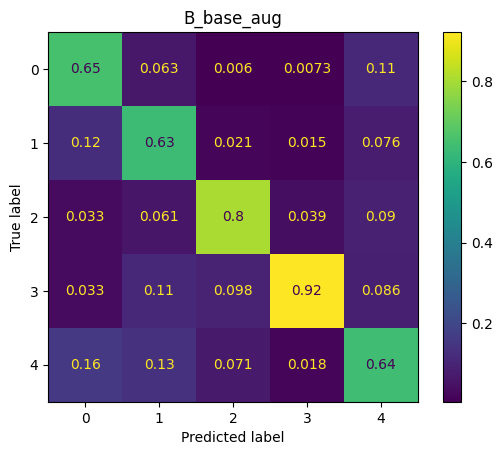

In [13]:
print(datetime.datetime.now())
ds_train_aug = augment_dataset(ds_train, 2)
model_b = create_convnext_base(DEFAULT_PARAMS)
df_train, df_test = run_task("B_base_aug", model_b, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS)
collector.add_task_results(df_train, df_test)
print(datetime.datetime.now())

In [20]:
model_b.model.save("/kaggle/working/artefacts/model_b.keras")

In [22]:
del model_b
del model

In [ ]:
print(datetime.datetime.now())
model_c = create_convnext_base(DEFAULT_PARAMS)
df_train, df_test = run_task("C_base_aug_wgts", model_c, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS, class_weights)
collector.add_task_results(df_train, df_test)  
print(datetime.datetime.now())

2024-03-28 22:34:17.720561
Using EarlyStopping
Epoch 1/50


W0000 00:00:1711665288.450122      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711665288.450599      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711665288.451167      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 30/132 ━━━━━━━━━━━━━━━━━━━━ 2:10 1s/step - accuracy: 0.4928 - loss: 1.4114

In [16]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy
0,A_base,0.457857,0.843224
0,B_base_aug,0.479417,0.832477


In [59]:
df_train

,accuracy,loss,val_accuracy,val_loss,task_id,epoch
0,0.569448,1.300454,0.646495,0.97445,a_base,0


In [14]:
df_test

,task_id,test_loss,test_accuracy
0,B_base_aug,0.479417,0.832477


In [61]:
ARTEFACTS_PATH = Path("artefacts")
ARTEFACTS_PATH.mkdir(parents=True, exist_ok=True)

In [53]:
ARTEFACTS_PATH

PosixPath('artefacts')

In [67]:
collector = ResultCollector(ARTEFACTS_PATH)
collector.add_task_results(df_train, df_test)
collector.add_task_results(df_train2, df_test2)

In [23]:
collector.add_train_details(df_train)
collector.add_test_scores(df_test)

In [71]:
collector.get_train_details()

,accuracy,loss,val_accuracy,val_loss,task_id,epoch
0,0.569448,1.300454,0.646495,0.974450,a_base,0
0,0.593480,1.192300,0.662617,0.946595,b_base_aug,0


In [72]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy
0,a_base,0.976603,0.642523
0,b_base_aug,0.943075,0.660280


In [68]:
pd.read_csv(ARTEFACTS_PATH / "train_details.csv")

,accuracy,loss,val_accuracy,val_loss,task_id,epoch
0,0.569448,1.300454,0.646495,0.974450,a_base,0
1,0.593480,1.192300,0.662617,0.946595,b_base_aug,0


In [70]:
pd.read_csv(ARTEFACTS_PATH / "test_scores.csv")

,task_id,test_loss,test_accuracy
0,a_base,0.976603,0.642523
1,b_base_aug,0.943075,0.660280


`older_code`

In [ ]:
#!rm -rf /kaggle/working/data
#!rm /kaggle/working/data.zip

In [ ]:
# import keras

# import pandas as pd
# import random
# import shutil
# import tensorflow as tf
# import os
# import zipfile

# from collections import Counter

# from pathlib import Path
# from sklearn.model_selection import train_test_split

# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from tensorflow.keras import layers, callbacks
# from tensorflow.keras.models import Model


# from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

# from tensorflow.data import Dataset

# from typing import NamedTuple, Tuple

# import matplotlib.pyplot as plt
# import seaborn as sns

In [9]:
# def data_cleanup() -> None:
#     # clean-up
#     try:
#         os.rmdir((data_path / "train_images"))
#         os.remove(file)
#     except Exception:
#          pass

In [5]:
df = create_test_record("test_task", [1.0, 2.0])

In [8]:
pd.concat([df, create_test_record("test_task", [1.0, 2.0])])

,task_id,test_loss,test_accuracy
0,test_task,1.0,2.0
0,test_task,1.0,2.0


In [12]:




# Large VGG-like model
def fatVGG(cifarInput, num_classes, name="vgg"):
    name = [name+str(i) for i in range(17)]
    
    # convolution and max pooling layers
    vgg = Conv2D(32, (3, 3), padding='same', activation='relu', name=name[0])(cifarInput)
    vgg = Conv2D(32, (3, 3), padding='same', activation='relu', name=name[1])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[2])(vgg)
    vgg = Dropout(0.25, name=name[3])(vgg)
    vgg = Conv2D(64, (3, 3), padding='same', activation='relu', name=name[4])(vgg)
    vgg = Conv2D(64, (3, 3), padding='same', activation='relu', name=name[5])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[6])(vgg)
    vgg = Dropout(0.25, name=name[7])(vgg)
    vgg = Conv2D(128, (3, 3), padding='same', activation='relu', name=name[8])(vgg)
    vgg = Conv2D(128, (3, 3), padding='same', activation='relu', name=name[9])(vgg)
    vgg = Conv2D(128, (3, 3), padding='same', activation='relu', name=name[10])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[11])(vgg)
    vgg = Dropout(0.25, name=name[12])(vgg)

    # classification layers
    vgg = Flatten(name=name[13])(vgg)
    vgg = Dense(512, activation='relu', name=name[14])(vgg)
    vgg = Dropout(0.5, name=name[15])(vgg)
    vgg = Dense(num_classes, activation='softmax', name=name[16])(vgg)
    return vgg


def model_convnext_tiny(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_convnext_base(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_convnext_tiny_1fc(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_effnet(params: Params) -> Model:
    
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_effnetv2(params: Params) -> Model:
    
    base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def effnet2(params: Params) -> Model:
    base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    base_model.trainable = False
    inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1024, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(1024, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(5, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model
    
    
#keras.utils.plot_model(mod.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


def train(task_id: str, model: Model,
             ds_train_: Dataset, ds_valid_: Dataset,
             params: Params, weights = None) -> pd.DataFrame:
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.001, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs,
        class_weight=weights
    )
   
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["task_id"] = task_id
    df_hist["epoch"] = df_hist.index
   
    return df_hist


def run_experiment(exp_id: str, sub_exp_id: int, model_fn: str,
                      ds_train_: Dataset, ds_valid_: Dataset, params: Params, weights = None) -> Tuple[Model, pd.DataFrame]:
    
    model = model_fn(params)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.001, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs,
        class_weight=weights
    )
    
    
    
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["exp_id"] = exp_id
    df_hist["sub_exp_id"] = sub_exp_id
    df_hist["epoch"] = df_hist.index
   
    return model, df_hist

In [13]:
def add_results(df_all_results, df_new_results):
    if df_all_results.empty:
        return df_new_results
    else:
        return pd.concat([df_all_results, df_new_results])
    

def add_test_results(df_all_results: pd.DataFrame, exp_id: str, res: list[float]):
    df_res = pd.DataFrame({"exp_id": [exp_id], "test_loss" : [res[0]], "test_accuracy": [res[1]]})
    if df_all_results.empty:
        return df_res
    else:
        return pd.concat([df_all_results, df_res])


def recover_results() -> pd.DataFrame:
    file = "results.csv"
    if Path(file).exists():
        return pd.read_csv(file)
    return pd.DataFrame()


def recover_test_results() -> pd.DataFrame:
    file = "test_results.csv"
    if Path(file).exists():
        return pd.read_csv(file)
    return pd.DataFrame()

In [14]:
def plot_experiment_results(df_history: pd.DataFrame, exp_id: str, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id == exp_id) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_loss = df[["epoch", "loss", "val_loss"]].groupby(["epoch"]).mean()
    df_loss_gap = df[["epoch", "loss_gap"]].groupby(["epoch"]).mean()
    df_acc = df[["epoch", "accuracy", "val_accuracy"]].groupby(["epoch"]).mean()
    df_loss.plot()
    df_loss_gap.plot()
    df_acc.plot();
    
def plot_experiments_comp(df_history: pd.DataFrame, exp_id: list, y_dim: str, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id.isin(exp_id)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","exp_id", y_dim]].groupby(["epoch", "exp_id"]).mean()
    sns.lineplot(data=df_grp, x="epoch", y=y_dim, hue="exp_id")

In [15]:
def plot_experiments_comp2(df_history: pd.DataFrame, exp_id: list, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id.isin(exp_id)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","exp_id", "val_accuracy", "val_loss", "loss_gap"]].groupby(["epoch", "exp_id"]).mean()
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 8))
    sns.lineplot(data=df_grp, x="epoch", y="val_accuracy", hue="exp_id",  ax=ax1)
    sns.lineplot(data=df_grp, x="epoch", y="val_loss", hue="exp_id",  ax=ax2)
    sns.lineplot(data=df_grp, x="epoch", y="loss_gap", hue="exp_id",  ax=ax3)

`main.py`

In [17]:
cwd = os.getcwd()
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), DEFAULT_PARAMS)
print(f"Class Weights: {class_weights}")

#df_results = recover_results()
#df_test_results = recover_test_results()

Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Class Weights: {0: 3.9368905243790246, 3: 0.3252317981456148, 1: 1.954956601187757, 2: 1.7935456831517183, 4: 1.6606131160263873}


In [15]:
# augmented datasets
#ds_train_aug = augment_dataset(ds_train, 1)
#ds_train_aug_lg = augment_dataset(ds_train, 2)
#ds_train_aug_xlg = augment_dataset(ds_train, 4)

In [16]:
df_results.head()

""


In [17]:
df_test_results.head()

""


`experiments/tasks`

In [24]:
DEFAULT_PARAMS = Params(255, 196, 2, True, 5, False)

In [25]:
ARTIFACTS_PATH = Path("artefacts").mkdir(parents=True, exist_ok=True)


In [26]:
def run_task(task_id: str, model_wrapper: ModelWrapper,
             ds_train_: Dataset, ds_valid_: Dataset, ds_test_: Dataset,
             params: Params, weights = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    model = model_wrapper.model
    # train
    df_train = train(task_id, model, ds_train, ds_valid, DEFAULT_PARAMS)
    # test
    test_result = model.evaluate(ds_test)
    df_test = create_test_record(task_id, test_result)
    # save CM too
    save_confusion_matrix(ds_test, model, task_id)
    return df_train, df_test

In [27]:
def create_test_record(task_id: str, result: list[float]):
    return pd.DataFrame({"task_id": [task_id], "test_loss" : [result[0]], "test_accuracy": [result[1]]})

Using EarlyStopping
Epoch 1/2


I0000 00:00:1711321282.183251     498 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711321282.236356     498 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321282.236806     498 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321282.237332     498 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/66 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5706 - loss: 1.2415

W0000 00:00:1711321380.232610     499 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321380.232985     499 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321380.233537     499 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5713 - loss: 1.2390

W0000 00:00:1711321390.771458     497 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321390.771793     497 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321390.772266     497 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321432.045138     499 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321432.045596     499 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321432.046045     499 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.5720 - loss: 1.2365 - val_accuracy: 0.6988 - val_loss: 0.7895
Epoch 2/2
66/66 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6807 - loss: 0.8515 - val_accuracy: 0.7463 - val_loss: 0.6947
Restoring model weights from the end of the best epoch: 2.
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7529 - loss: 0.6842
 1/22 ━━━━━━━━━━━━━━━━━━━━ 3:13 9s/step

W0000 00:00:1711321592.226407     497 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321592.226798     497 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321592.227242     497 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step


W0000 00:00:1711321623.516857     496 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321623.517186     496 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321623.517606     496 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


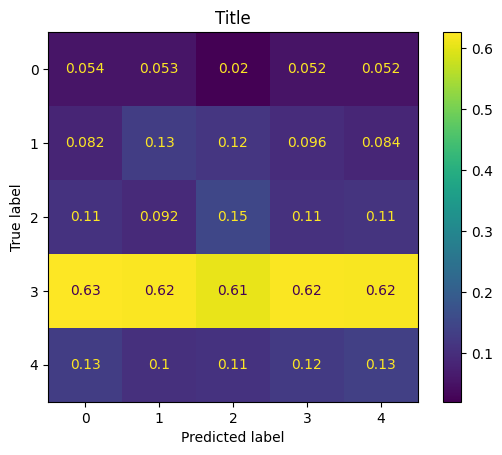

In [28]:
baseline_model = create_model(tf.keras.applications.ConvNeXtBase, "baseline_model", DEFAULT_PARAMS)
df_train, df_test = run_task("convnextbase", baseline_model, ds_train, ds_valid, ds_test, DEFAULT_PARAMS)

In [29]:
df_train

,index,accuracy,loss,val_accuracy,val_loss,task_id,epoch
0,0,0.617979,1.073591,0.698832,0.789482,convnextbase,0
1,1,0.688556,0.830277,0.746262,0.694713,convnextbase,1


In [31]:
df_test

,task_id,test_loss,test_accuracy
0,convnextbase,0.682921,0.758879


In [28]:
    df_train = run_task("model_convnext_tiny", baseline_model.model,
                   ds_train, ds_valid, DEFAULT_PARAMS)

Using EarlyStopping
Epoch 1/2


W0000 00:00:1711316805.446230      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316805.446760      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316805.447357      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/66 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5939 - loss: 1.1857

W0000 00:00:1711316897.558286      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316897.558753      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316897.559329      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5944 - loss: 1.1837

W0000 00:00:1711316907.260369      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316907.260831      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316907.261298      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316937.803347      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316937.803829      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316937.804396      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.5949 - loss: 1.1818 - val_accuracy: 0.7063 - val_loss: 0.7846
Epoch 2/2
66/66 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6832 - loss: 0.8474 - val_accuracy: 0.7393 - val_loss: 0.6889
Restoring model weights from the end of the best epoch: 2.


In [51]:
df_results = add_results(df_results, df_hist)

In [52]:
df_results

,index,accuracy,loss,val_accuracy,val_loss,exp_id,epoch
0,0,0.625536,1.054757,0.706308,0.784627,model_convnext_tiny,0
1,1,0.690738,0.827267,0.739252,0.688928,model_convnext_tiny,1


In [30]:
baseline_model.model.evaluate(ds_valid)

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7351 - loss: 0.6851


[0.6893031597137451, 0.7392523288726807]

In [31]:
tr = baseline_model.model.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "convnext_tiny", tr)
tr

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7459 - loss: 0.6785


[0.6790671348571777, 0.7535046935081482]

In [ ]:
baseline_model.base_model.trainable = True
df_hist2 = run_task("convnext_tiny_ft", baseline_model.model,
                   ds_train, ds_valid, DEFAULT_PARAMS)

In [ ]:
tr2 = baseline_model.model.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "convnext_tiny_ft", tr2)
tr2

In [ ]:
df_test_results

22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step


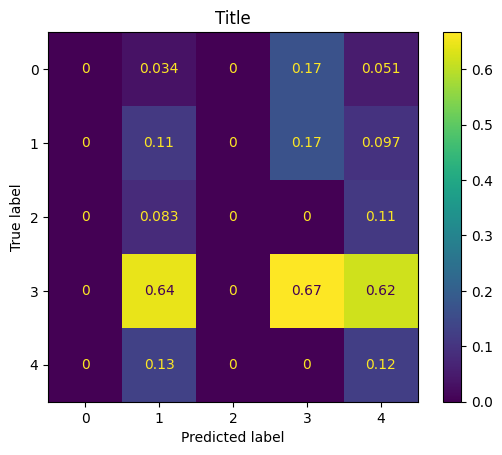

In [43]:
plot_confusion_matrix(ds_test, baseline_model.model)

In [ ]:
df_hist = run_task("model_convnext_tiny", baseline_model.model,
                   ds_train, ds_valid, DEFAULT_PARAMS)

In [ ]:
(m, df_hist) = run_experiment("model_convnext_tiny", 1, model_convnext_tiny, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m.evaluate(ds_test)

In [ ]:
(m1, df_hist) = run_experiment("model_convnext_base_orig_img", 1, model_convnext_base, augment_dataset(ds_train, 4), ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m1.evaluate(ds_test)

In [ ]:
(m1a, df_hist) = run_experiment("model_convnext_base_orig_img_all", 1, model_convnext_base, augment_dataset(ds_train, 1), ds_valid, DEFAULT_PARAMS, class_weights)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m1.evaluate(ds_test)

In [ ]:
(m1b, df_hist) = run_experiment("model_convnext_base_orig_img_all_no_wgt", 1, model_convnext_base, augment_dataset(ds_train, 1), ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m1b.evaluate(ds_test)

In [ ]:
(m2, df_hist) = run_experiment("model_convnext_tiny_aug_sm", 1, model_convnext_tiny, ds_train_aug, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m2.evaluate(ds_test)

In [ ]:
plot_experiments_comp(df_results,["model_convnext_tiny", "model_convnext_tiny_aug", "model_convnext_tiny_aug4_sm"], "val_accuracy")

In [ ]:
plot_experiments_comp(df_results,["model_convnext_tiny", "model_convnext_tiny_aug"], "val_loss")

In [ ]:
(m3, df_hist) = run_experiment("model_convnext_tiny_aug4_sm", 1, model_convnext_tiny, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m3.evaluate(ds_test)

In [ ]:
df_results.head()

In [ ]:
plot_experiments_comp(df_results,["model_convnext_tiny_aug", "model_convnext_tiny_sm", "model_convnext_tiny_aug_sm", "model_convnext_tiny_aug4_sm"], "val_accuracy")

In [ ]:
(m4, df_hist) = run_experiment("model_convnext_tiny_1fc", 1, model_convnext_tiny_1fc, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m4.evaluate(ds_test)

In [ ]:
plot_experiments_comp2(df_results,["model_convnext_tiny_1fc", "model_convnext_tiny_aug", "model_convnext_tiny_sm", "model_convnext_tiny_aug_sm", "model_convnext_tiny_aug4_sm"], "val_loss")

In [ ]:
(m4, df_hist) = run_experiment("model_effnetv2", 1, model_effnetv2, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m4.evaluate(ds_test)

In [ ]:
(m5, df_hist) = run_experiment("model_effnet", 1, model_effnet, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

r5 = m5.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "model_effnet", r5)
print(r5)

In [ ]:
(m6, df_hist) = run_experiment("model_effnet_wgts", 1, model_effnet, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS, class_weights)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

r6 = m6.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "model_effnet", r6)
print(r6)

In [ ]:
print(r6)

In [ ]:
(m7, df_hist) = run_experiment("effnet2", 1, effnet2, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS, class_weights)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

r7 = m7.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "effnet2", r6)
print(r7)

In [ ]:
plot_experiments_comp2(df_results,["model_effnet", "model_effnet_wgts"])

In [ ]:
plot_experiments_comp2(df_results,["model_convnext_tiny_1fc", "model_convnext_tiny_aug", "model_effnetv2", "model_effnet"])

In [ ]:
params = DEFAULT_PARAMS
weights = class_weights
    
base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(x)
#x = keras.layers.Dense(1024, activation="relu")(x)
#x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001,
    patience=params.early_stopping_patience,
    restore_best_weights=True,
    verbose = 1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.3, 
    patience = 3, min_delta = 0.001, 
    mode = 'min', verbose = 1)

cbs = []
if params.early_stopping:
    print("Using EarlyStopping")
    cbs += [early_stopping]
if params.adjust_learning_rate:
    print("Using ReduceLROnPlateau")
    cbs += [reduce_lr]

history = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight = None
)


In [ ]:
model.evaluate(ds_test)

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=1e-5),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

history2 = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight=None
)

In [ ]:
model.evaluate(ds_test)
# [0.4968397915363312, 0.8268691301345825]

In [ ]:
model_eff = model

In [ ]:
params = DEFAULT_PARAMS
weights = class_weights
    
base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001,
    patience=params.early_stopping_patience,
    restore_best_weights=True,
    verbose = 1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.3, 
    patience = 3, min_delta = 0.001, 
    mode = 'min', verbose = 1)

cbs = []
if params.early_stopping:
    print("Using EarlyStopping")
    cbs += [early_stopping]
if params.adjust_learning_rate:
    print("Using ReduceLROnPlateau")
    cbs += [reduce_lr]

history = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight = weights
)

In [ ]:
model.evaluate(ds_test)

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=1e-5),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

history2 = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight = weights
)

In [18]:
model.model.evaluate(ds_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8424 - loss: 0.4587


[0.46237561106681824, 0.8378504514694214]

In [21]:
del ds_train

In [ ]:
preds = model.predict(ds_test)

In [ ]:
m1.evaluate(ds_test)

In [ ]:
m1.evaluate(ds_valid)

In [33]:
probabilities = model.model.predict(xs)
predictions = np.argmax(probabilities, axis=1)
#Counter(predictions)

  1/134 ━━━━━━━━━━━━━━━━━━━━ 19:48 9s/step

W0000 00:00:1711657247.258119      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711657247.258444      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711657247.258901      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711657247.259891      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711657247.260266      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711657247.260674      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711657247.261057      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711657247.261437      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/134 ━━━━━━━━━━━━━━━━━━━━ 45s 273ms/step


W0000 00:00:1711657283.500852      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711657283.501303      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711657283.501740      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711657283.502112      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711657283.502524      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711657283.502892      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711657283.503265      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711657283.503624      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [32]:
xs = np.concatenate([x for x, y in ds_test], axis=0)

In [ ]:
probabilities = m1.predict(ds_test2)
predictions = np.argmax(probabilities, axis=1)
Counter(predictions)

In [ ]:
probabilities = m1a.predict(ds_test2)
predictions = np.argmax(probabilities, axis=1)
Counter(predictions)

In [27]:
import matplotlib.pyplot as plt

In [28]:
y = np.concatenate([y for x, y in ds_test], axis=0)
ys = [np.argmax(x) for x in y]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(ys, predictions, labels=[0,1,2,3,4], normalize='pred')
print(result)

[[0.08       0.05311778 0.05841121 0.04581006 0.05308219]
 [0.08       0.09237875 0.08878505 0.10018622 0.10273973]
 [0.09333333 0.13163972 0.11448598 0.10763501 0.09075342]
 [0.58       0.58198614 0.61915888 0.63277467 0.60958904]
 [0.16666667 0.1408776  0.11915888 0.11359404 0.14383562]]


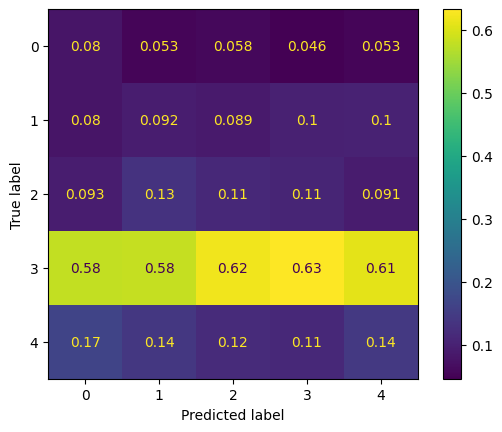

In [29]:
disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

In [34]:
ds_test2 = image_dataset_from_directory(
        Path("/kaggle/working/data/test/"),
        labels='inferred',
        label_mode='categorical',
        image_size=[255, 255],
        batch_size=196,
        shuffle=False
    )

Found 4280 files belonging to 5 classes.


In [36]:
model.model.evaluate(ds_test2)

22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7605 - loss: 0.6582


[0.4664035141468048, 0.8378504514694214]

22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


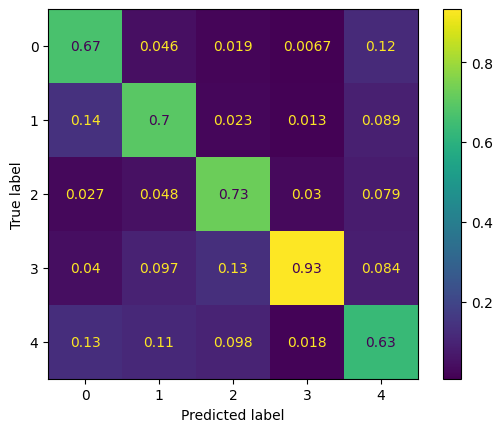

In [35]:
probabilities = model.model.predict(ds_test2)
predictions = np.argmax(probabilities, axis=1)
#Counter(predictions)

y = np.concatenate([y for x, y in ds_test2], axis=0)
ys = [np.argmax(x) for x in y]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(ys, predictions, labels=[0,1,2,3,4], normalize='pred')
disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

In [ ]:


def plot_confusion_matrix(ds: Dataset, model: Model) -> None:
    probabilities = model.predict(ds)
    predictions = np.argmax(probabilities, axis=1)

    one_hot_labels = np.concatenate([y for x, y in ds], axis=0)
    labels = [np.argmax(x) for x in one_hot_labels]
    
    result = confusion_matrix(labels, predictions, labels=[0,1,2,3,4], normalize='pred')
    disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
    disp.plot()
    plt.show()

In [ ]:
m1b.evaluate(ds_valid)

In [ ]:
m1b.evaluate(ds_test)

In [ ]:
plot_confusion_matrix(ds_test2, m1b)